In [167]:
#  import libraries
import h5py
import os, sys
import zipfile
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt


# --- Configuration ---
sys.path.insert(0, '../../../config')
from _utility_imports import *

In [168]:
# Path to the ZIP file
# check if .zip file exists
# if not os.path.exists("results.zip"):
#     print("The file 'results.zip' does not exist.")
#     sys.exit()
    
# zip_file_path = "results.zip"
# # zip_file_path = "results_loc_joint.zip"
# output_folder = "results"

# # Unzip the file
# if os.path.exists(zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         # Create the output folder if it doesn't exist
#         if not os.path.exists(output_folder):
#             os.makedirs(output_folder)
#         zip_ref.extractall(output_folder)
#     print(f"Extracted '{zip_file_path}' to '{output_folder}'")
# else:
#     print(f"The file '{zip_file_path}' does not exist.")


Reading data from results/true-wrong-icepack.h5...
Dataset 'Lxy' extracted with shape (2,)
Dataset 'b_io' extracted with shape (2,)
Dataset 'ensemble_nurged_state' extracted with shape (1700, 121)
Dataset 'ensemble_true_state' extracted with shape (1700, 121)
Dataset 'nxy' extracted with shape (2,)
Dataset 'obs_index' extracted with shape (8,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 't' extracted with shape (121,)
Dataset 'w' extracted with shape (1700, 8)
Data extraction complete.
At h_indx = 120 profile 
(8,)


Text(0.5, 1.0, 'end profile at h_indx = 120')

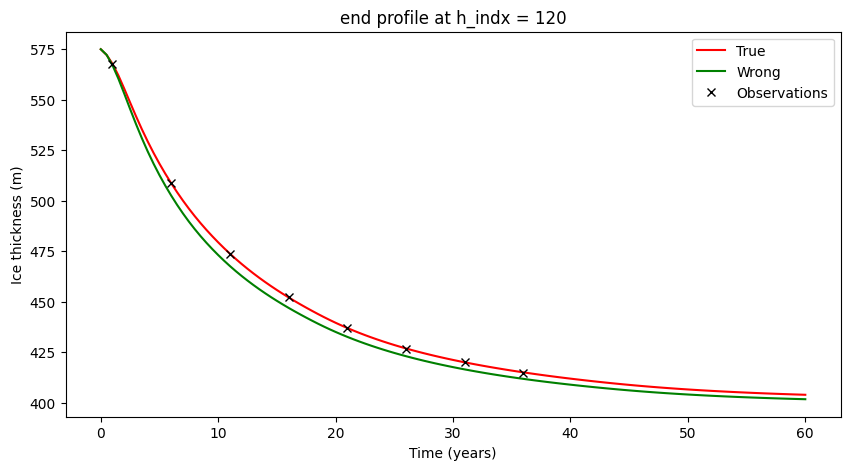

In [177]:
results_dir = "results"
filter_type = "true-wrong"
# file_path = f"results/{filter_type}-icepack.h5"
file_path = f"{results_dir}/{filter_type}-icepack.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
ensemble_true_state = datasets_tw['ensemble_true_state']
ensemble_nurged_state = datasets_tw['ensemble_nurged_state']
w = datasets_tw['w']
ind_m = datasets_tw['obs_index']
tm_m = datasets_tw['obs_max_time'][0]

nt = ensemble_true_state.shape[1]; num_steps = nt-1
ndim = ensemble_true_state.shape[0]
hdim = ndim//4 # [h,u,v,smb]

# plot the ensemble_true_state and ensemble_nurged_state
htrue = ensemble_true_state[:hdim,:]
hnurge = ensemble_nurged_state[:hdim,:]

# define profile flag
profile_flag = "end" # begining, middle, end, random
# h_indx = 0 # first profile
# h_indx = htrue.shape[1]//2 # middle profile
# h_indx = htrue.shape[1]-1 # last profile
# h_indx = np.random.randint(htrue.shape[1])  # random profile
if profile_flag == "begining":
    h_indx = 0 # first profile
elif profile_flag == "middle":
    h_indx = htrue.shape[1]//2
elif profile_flag == "end":
    h_indx = htrue.shape[1]-1
elif profile_flag == "random":
    h_indx = np.random.randint(htrue.shape[1])

print(f"At h_indx = {h_indx} profile ")

h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]

plt.figure(figsize=(10,5))
plt.plot(t,h_true,'r',label='True')
plt.plot(t,h_nurged,'g',label='Wrong')
obs = w[h_indx,:]; print(obs.shape)
plt.plot(t[ind_m],obs,'kx',label="Observations")
plt.xlabel('Time (years)')
plt.ylabel('Ice thickness (m)')
plt.legend()
plt.title(f"{profile_flag} profile at h_indx = {h_indx}")

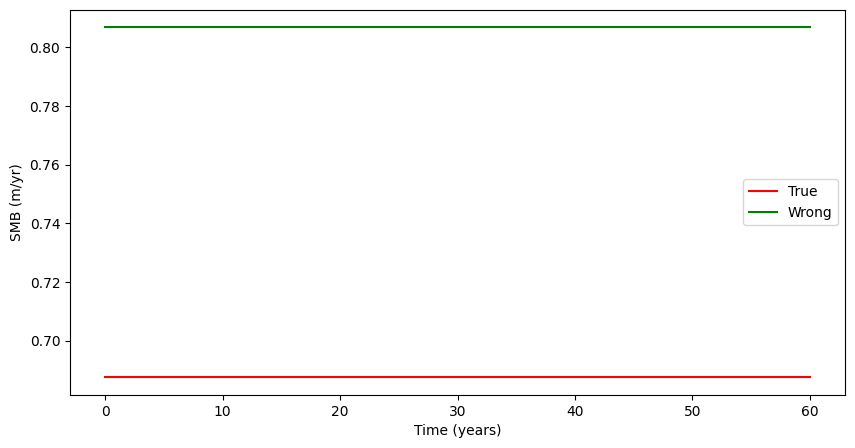

In [178]:
# extract smb
smbtrue = ensemble_true_state[3*hdim:,:]
smbnurged = ensemble_nurged_state[3*hdim:,:]

# plot the smbtrue
plt.figure(figsize=(10,5))
plt.plot(t,smbtrue[h_indx,:],'r',label='True')
plt.plot(t,smbnurged[h_indx,:],'g',label='Wrong')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.legend()

In [179]:
filter_type = "EnKF"
file_path = f"{results_dir}/{filter_type}-icepack.h5"
datasets = extract_datasets_from_h5(file_path)
ensemble_vec_full = datasets["ensemble_vec_full"]
ensemble_vec_mean = datasets["ensemble_vec_mean"] 
ensemble_bg       = datasets["ensemble_bg"]


Reading data from results/EnKF-icepack.h5...
Dataset 'ensemble_bg' extracted with shape (1700, 121)
Dataset 'ensemble_vec_full' extracted with shape (1700, 32, 121)
Dataset 'ensemble_vec_mean' extracted with shape (1700, 121)
Data extraction complete.


In [180]:
from firedrake import *
import firedrake

Lx, Ly = datasets_tw["Lxy"][0], datasets_tw["Lxy"][1]
nx, ny = datasets_tw["nxy"][0], datasets_tw["nxy"][1]

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
x, y = firedrake.SpatialCoordinate(mesh)
b_in, b_out = datasets_tw["b_io"][0], datasets_tw["b_io"][1]
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

# form a rectangular mesh and get x, y coordinates
x, y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
print(nx, ny, Lx, Ly)

12 8 5000 1200


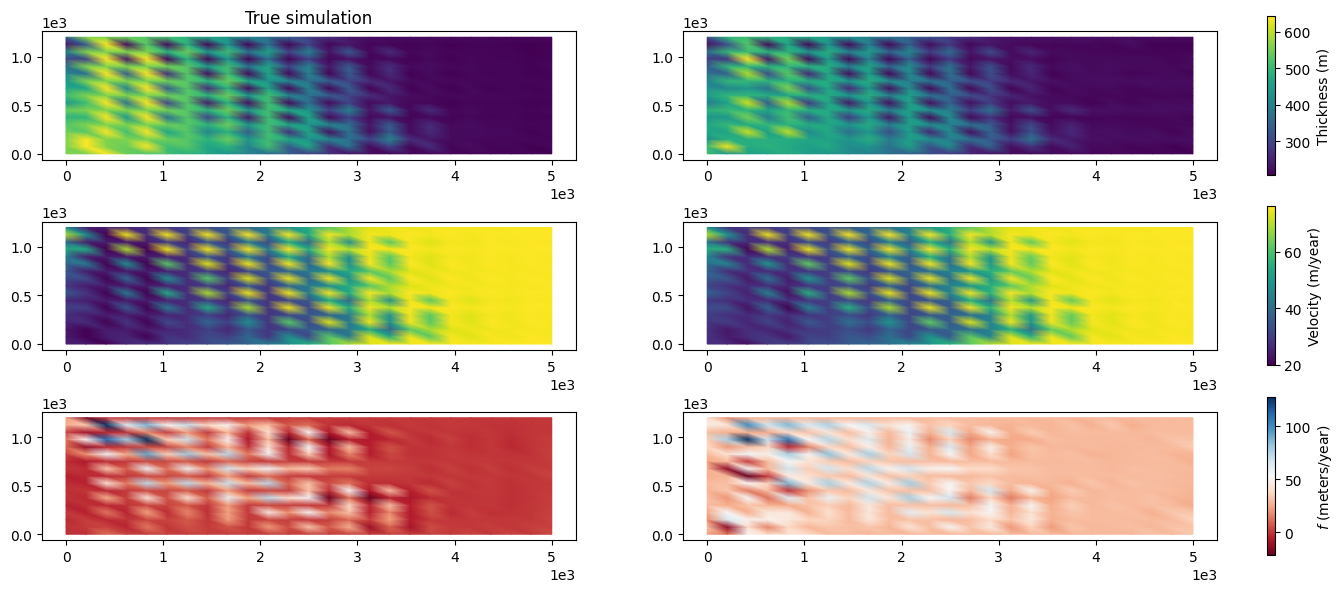

In [181]:
from firedrake import div
import copy
import icepack
import icepack.plot
fig, axes = icepack.plot.subplots(3,2, figsize=(16,7))
step = nt-1
hhtrue = firedrake.Function(Q)
uutrue = firedrake.Function(V)
hhtrue.dat.data[:] = copy.deepcopy(ensemble_true_state[:hdim,step])
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0])
fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation")

# ploting the velocity field
uutrue.dat.data[:,0] = copy.deepcopy(ensemble_true_state[hdim:2*hdim,step])
uutrue.dat.data[:,1] = copy.deepcopy(ensemble_true_state[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uutrue, axes=axes[1][0])
fig.colorbar(colors, ax=axes[1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# ploting the basal shear stress
f = firedrake.interpolate(div(hhtrue*uutrue), Q)
colors = firedrake.tripcolor(f, axes=axes[2][0], cmap="RdBu")
fig.colorbar(colors, ax=axes[2], fraction=0.012, pad=0.04, label=r"$f$ (meters/year)")

# axes[0][1].set_title("EnKF simulation")
# axes[0][1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")
hhenkf = firedrake.Function(Q)
uuenkf = firedrake.Function(V)
hhenkf.dat.data[:] = copy.deepcopy(ensemble_vec_mean[:hdim,step])
colors = firedrake.tripcolor(hhenkf, axes=axes[0][1])
# fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")


# ploting the velocity field
uuenkf.dat.data[:,0] = copy.deepcopy(ensemble_vec_mean[hdim:2*hdim,step])
uuenkf.dat.data[:,1] = copy.deepcopy(ensemble_vec_mean[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uuenkf, axes=axes[1][1])


# ploting the basal shear stress
f = firedrake.interpolate(div(hhenkf*uuenkf), Q)
colors = firedrake.tripcolor(f, axes=axes[2][1], cmap="RdBu")

Text(0, 0.5, 'thickness (m)')

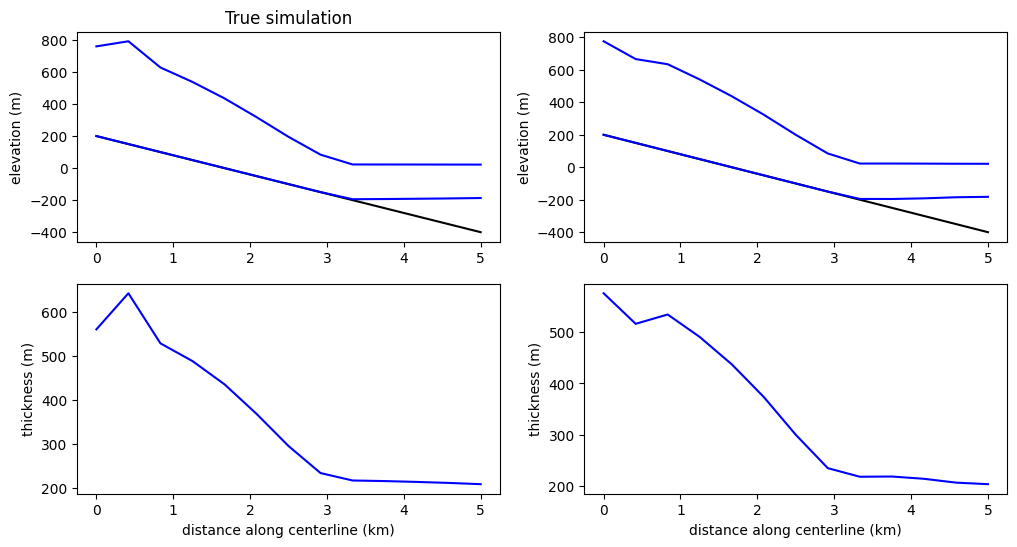

In [182]:
# we can draw some transects through the domain to see what the surface, bed, and ice base elevation look like

xs = np.array([(Lx * k /nx, 0) for k in range(nx + 1)])
s = icepack.compute_surface(thickness = hhtrue, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhtrue.at(xs, tolerance=1e-10))

fig, axes = plt.subplots(2,2, figsize=(12, 6))
axes[0,0].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,0].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,0].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,0].set_xlabel("distance along centerline (km)")
axes[0,0].set_ylabel("elevation (m)")
axes[0,0].set_title("True simulation")

axes[1,0].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,0].set_xlabel("distance along centerline (km)")
axes[1,0].set_ylabel("thickness (m)")


s = icepack.compute_surface(thickness = hhenkf, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhenkf.at(xs, tolerance=1e-10))

axes[0,1].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,1].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,1].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,1].set_xlabel("distance along centerline (km)")
axes[0,1].set_ylabel("elevation (m)")
# axes[0,1].set_title("DEnKF simulation")
# axes[0,1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")

axes[1,1].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,1].set_xlabel("distance along centerline (km)")
axes[1,1].set_ylabel("thickness (m)")

Text(0.5, 1.0, 'end profile at u_indx = 545 and v_indx = 970')

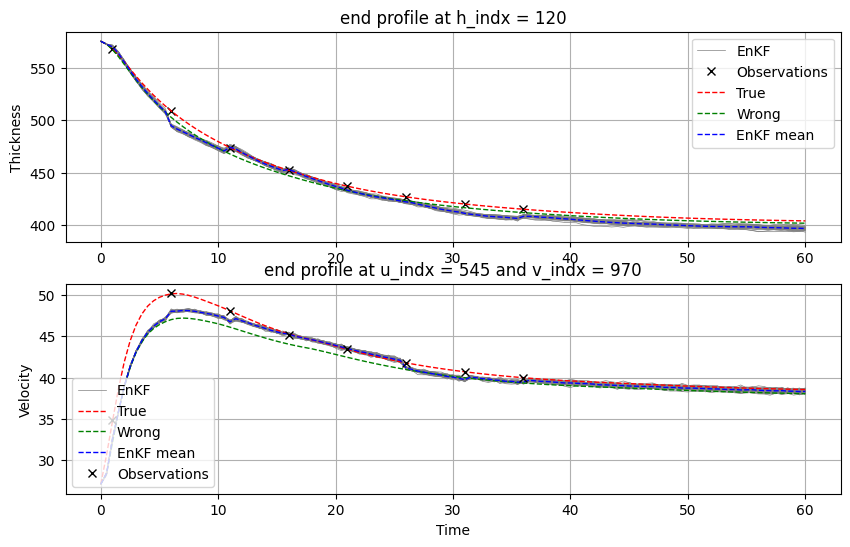

In [183]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

# h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])
obs_h = w[h_indx,:]


# plot the h middle profile
# h_indx = hens.shape[1]//2
hens = ensemble_vec_mean[:hdim,:]
h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = ensemble_vec_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
Nens = ensemble_vec_full.shape[1]
for ens in range(Nens):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t[ind_m],obs_h,'kx',label="Observations")

ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_nurged,'--g',label='Wrong',linewidth=1)
ax[0].plot(t,h_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
# ax[0].set_ylim([350, 500])
# ax[0].set_xlim([1, 250])
# ax[0].set_xlabel('Time')
ax[0].grid()
ax[0].set_ylabel('Thickness')
ax[0].set_title(f"{profile_flag} profile at h_indx = {h_indx}")

# plot the u middle profile
# u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
# v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
# uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
obs_u = w[u_indx,:]
obs_v = w[v_indx,:]
uobs = np.sqrt(obs_u**2 + obs_v**2)
u_true = ensemble_true_state[u_indx,:]
v_true = ensemble_true_state[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_nurge = ensemble_nurged_state[u_indx,:]
v_nurge = ensemble_nurged_state[v_indx,:]
unurge = np.sqrt(u_nurge**2 + v_nurge**2)
u_ens_mean = ensemble_vec_mean[u_indx,:]
v_ens_mean = ensemble_vec_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = ensemble_vec_full[u_indx,:,:].T
v_ens_mem  = ensemble_vec_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(Nens):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,unurge,'--g',label='Wrong',linewidth=1)
ax[1].plot(t,uens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
ax[1].plot(t[ind_m],uobs,'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].grid()
ax[1].set_title(f"{profile_flag} profile at u_indx = {u_indx} and v_indx = {v_indx}")


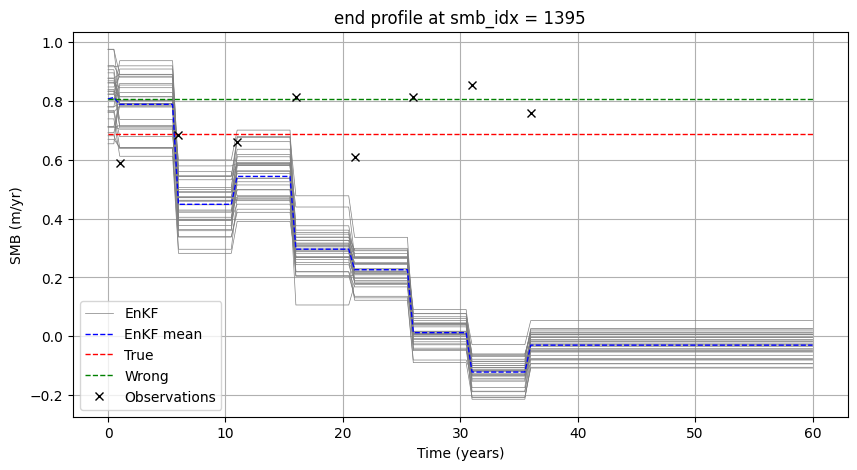

In [184]:
# plot the smb middle profile
smb_idx = 3*hdim + h_indx
smbtrue = ensemble_true_state[smb_idx,:]
smb_nurged = ensemble_nurged_state[smb_idx,:]
smbs_ens_mean = ensemble_vec_mean[smb_idx,:]
smb_ens = ensemble_vec_full[smb_idx,:,:].T
smb_obs = w[smb_idx,:]
plt.figure(figsize=(10,5))
for ens in range(Nens):
    plt.plot(t,smb_ens[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")
plt.plot(t,smbs_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
plt.plot(t,smbtrue,'--r',label='True',linewidth=1)
plt.plot(t,smb_nurged,'--g',label='Wrong',linewidth=1)
plt.plot(t[ind_m],smb_obs,'kx',label='Observations')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.title(f"{profile_flag} profile at smb_idx = {smb_idx}")
plt.grid()
plt.legend()


In [ ]:
# h_indx = np.random.randint(htrue.shape[1])
# h_indx = np.linspace(0,htrue.shape[1]-1,10).astype(int)


# # plot the smb middle profile
# smb_idx = 3*hdim + h_indx
# smbtrue = statevec_true[smb_idx,:]
# smb_nurged = statevec_nurged[smb_idx,:]
# smbs_ens_mean = statevec_ens_mean[smb_idx,:]
# smb_ens = eensemble_nurged_state[smb_idx,:,:].T
# smb_obs = w[smb_idx,:]
# plt.figure(figsize=(10,5))
# for ens in range(Nens):
#     plt.plot(t,smb_ens[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")
# plt.plot(t,smbs_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# plt.plot(t,smbtrue,'--r',label='True',linewidth=1)
# plt.plot(t,smb_nurged,'--g',label='Wrong',linewidth=1)
# plt.plot(t[ind_m],smb_obs,'kx',label='Observations')
# plt.xlabel('Time (years)')
# plt.ylabel('SMB (m/yr)')
# plt.title(f"{profile_flag} profile at smb_idx = {smb_idx}")
# plt.grid()
# plt.legend()

In [ ]:
observed_dof = np.where(w.any(axis=1))[0]
observed_dof

array([   0,    1,    2, ..., 1697, 1698, 1699], shape=(1700,))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def gaspari_cohn(r):
    """
    Compute the Gaspari-Cohn localization function.
    
    Parameters:
    r (numpy array): Normalized distance (d / r0), where d is the Euclidean distance 
                     and r0 is the localization radius.
    
    Returns:
    numpy array: Localization weights corresponding to r.
    """
    gc = np.zeros_like(r)  # Initialize localization weights

    # Case 0 <= r < 1
    mask1 = (r >= 0) & (r < 1)
    gc[mask1] = (((-0.25 * r[mask1] + 0.5) * r[mask1] + 0.625) * r[mask1] - 5.0 / 3.0) * r[mask1]**2 + 1

    # Case 1 <= r < 2
    mask2 = (r >= 1) & (r < 2)
    gc[mask2] = ((((1.0 / 12.0 * r[mask2] - 0.5) * r[mask2] + 0.625) * r[mask2] + 5.0 / 3.0) * r[mask2] - 5.0) * r[mask2] + 4.0 - 2.0 / (3.0 * np.where(r[mask2] == 0, 1e-10, r[mask2]))

    # Case r >= 2 (default to 0)
    return gc


def create_tapering_matrix(grid_x, grid_y, localization_radius):
    """
    Create a tapering matrix using the Gaspari-Cohn localization function.

    Parameters:
    grid_x (numpy array): X-coordinates of grid points (1D array).
    grid_y (numpy array): Y-coordinates of grid points (1D array).
    localization_radius (float): Cutoff radius beyond which correlations are zero.

    Returns:
    numpy array: Tapering matrix (NxN), where N = number of grid points.
    """
    # Stack grid points into (N, 2) array where N is the number of points
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Compute pairwise Euclidean distances
    distance_matrix = cdist(grid_points, grid_points, metric='euclidean')

    # Normalize distances by localization radius
    normalized_distances = distance_matrix / localization_radius

    # Apply the Gaspari-Cohn function to get tapering weights
    tapering_matrix = gaspari_cohn(normalized_distances)

    return tapering_matrix


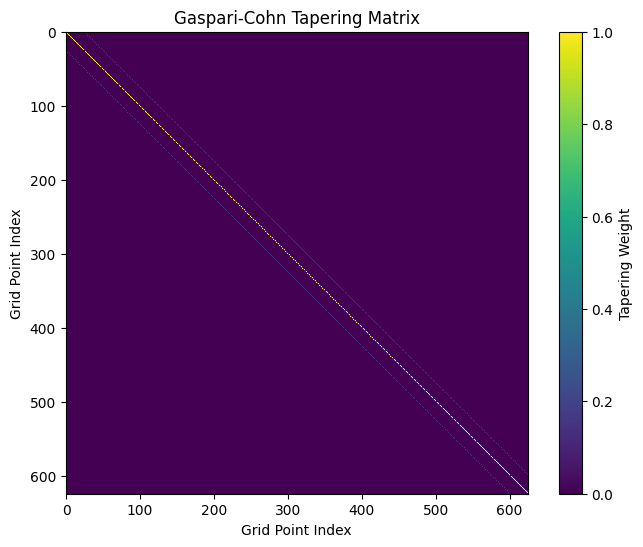

In [ ]:
# Create a 2D grid (5x5 points)
x = np.linspace(0, 40, 25)  # X-coordinates
y = np.linspace(0, 40, 25)  # Y-coordinates
grid_x, grid_y = np.meshgrid(x, y)  # Create mesh grid

# Set localization radius
r0 = 1.5  # Influence radius for tapering

# Compute the tapering matrix
tapering_matrix = create_tapering_matrix(grid_x, grid_y, r0)

# Plot the tapering matrix
plt.figure(figsize=(8, 6))
plt.imshow(tapering_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Tapering Weight')
plt.title('Gaspari-Cohn Tapering Matrix')
plt.xlabel('Grid Point Index')
plt.ylabel('Grid Point Index')
plt.show()


In [ ]:
def compute_adaptive_localization_radius(ensemble, grid_x, grid_y, base_radius=2.0, method='variance'):
    """
    Compute an adaptive localization radius for each grid point.

    Parameters:
    ensemble (numpy array): Ensemble state matrix (N_grid x N_ens).
    grid_x (numpy array): X-coordinates of grid points (1D array).
    grid_y (numpy array): Y-coordinates of grid points (1D array).
    base_radius (float): Default radius before adaptation.
    method (str): 'variance', 'observation_density', or 'correlation'.

    Returns:
    numpy array: Adaptive localization radius for each grid point.
    """
    num_points, Nens = ensemble.shape  # Get grid size and ensemble size
    adaptive_radius = np.full(num_points, base_radius)  # Default radius

    if method == 'variance':
        # Compute ensemble variance at each grid point
        ensemble_variance = np.var(ensemble, axis=1)

        # Normalize variance (relative to max spread)
        normalized_variance = ensemble_variance / np.max(ensemble_variance)

        # Scale localization radius based on variance
        adaptive_radius *= (1 + normalized_variance)

    elif method == 'observation_density':
        # Compute observation density (using a Gaussian kernel approach)
        grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
        obs_density = np.sum(np.exp(-cdist(grid_points, grid_points, 'euclidean')**2 / base_radius**2), axis=1)

        # Normalize observation density
        normalized_density = obs_density / np.max(obs_density)

        # Decrease localization radius in high-density regions
        adaptive_radius *= (1 - normalized_density)

    elif method == 'correlation':
        # Compute correlation matrix from the ensemble
        correlation_matrix = np.corrcoef(ensemble, rowvar=True)

        # Set radius where correlation drops below 1/sqrt(Nens-1)
        threshold = 1 / np.sqrt(Nens - 1)
        for i in range(num_points):
            below_threshold = np.where(correlation_matrix[i, :] < threshold)[0]
            if below_threshold.size > 0:
                adaptive_radius[i] = base_radius * np.min(below_threshold) / num_points  # Scale adaptively

    else:
        raise ValueError("Invalid method. Choose 'variance', 'observation_density', or 'correlation'.")

    return adaptive_radius


In [ ]:
# Generate a synthetic ensemble (100 grid points, 10 ensemble members)
N_grid = 1000
N_ens = 30
ensemble = np.random.rand(N_grid, N_ens)

# Create synthetic grid coordinates (randomized for this example)
grid_x = np.linspace(0, 10, N_grid)
grid_y = np.linspace(0, 10, N_grid)

# Compute adaptive localization radius using variance-based adaptation
adaptive_radius = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, base_radius=2.0, method='variance')

# Print sample of computed localization radii
print("Sample Adaptive Localization Radii:", adaptive_radius[:10])


Sample Adaptive Localization Radii: [3.13120742 3.18668887 3.22770535 3.0384717  3.29482265 3.10694966
 3.56554508 3.0490591  3.30042232 3.24315229]


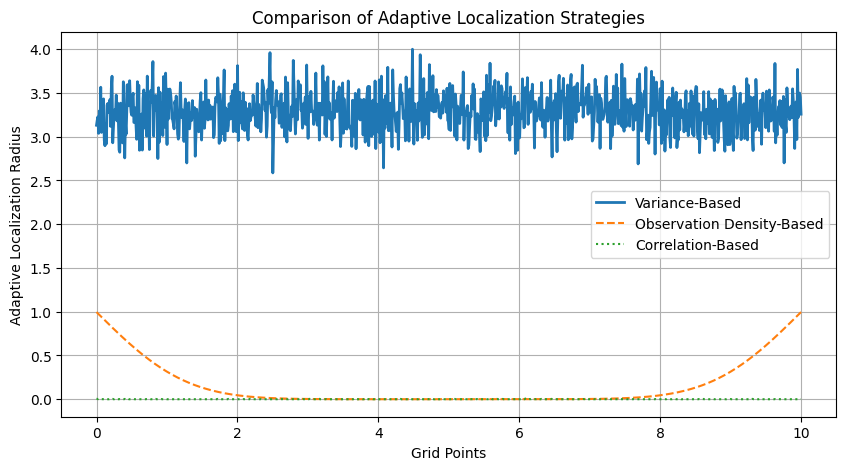

In [ ]:
import matplotlib.pyplot as plt

# Compute localization radius with different methods
radius_variance = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='variance')
radius_obs_density = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='observation_density')
radius_correlation = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='correlation')

# Plot adaptive localization radii
plt.figure(figsize=(10, 5))
plt.plot(grid_x, radius_variance, label='Variance-Based', linewidth=2)
plt.plot(grid_x, radius_obs_density, label='Observation Density-Based', linestyle='--')
plt.plot(grid_x, radius_correlation, label='Correlation-Based', linestyle='dotted')
plt.xlabel('Grid Points')
plt.ylabel('Adaptive Localization Radius')
plt.title('Comparison of Adaptive Localization Strategies')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# pip install iterative_ensemble_smoother

import iterative_ensemble_smoother as ies
from iterative_ensemble_smoother.experimental import AdaptiveESMDA

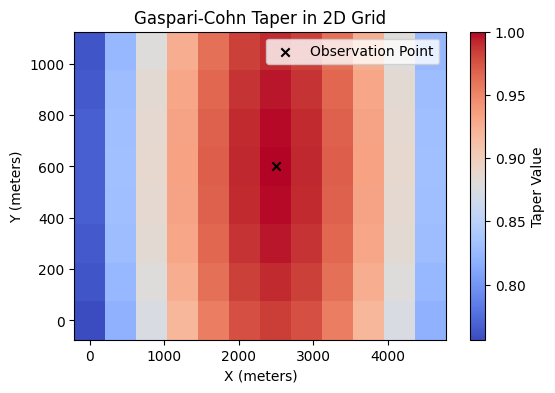

In [ ]:
import numpy as np

def gaspari_cohn(r):
    """
    Gaspari-Cohn taper function for localization in EnKF.
    Defined for 0 <= r <= 2.
    """
    r = np.abs(r)
    taper = np.zeros_like(r)
    
    mask1 = (r >= 0) & (r <= 1)
    mask2 = (r > 1) & (r <= 2)

    taper[mask1] = (((-0.25 * r[mask1] + 0.5) * r[mask1] + 0.625) * r[mask1] - 5/3) * r[mask1]**2 + 1
    taper[mask2] = ((((1/12 * r[mask2] - 0.5) * r[mask2] + 0.625) * r[mask2] + 5/3) * r[mask2] - 5) * r[mask2]**2 + 4 - 2/(3 * r[mask2])

    return np.maximum(taper, 0)  # Ensure non-negative values

# Domain parameters
Lx, Ly = 5000, 1200  # Domain size
nx, ny = 12, 8  # Number of grid points
dx, dy = Lx / nx, Ly / ny  # Grid spacing

# Create 2D grid
x_grid = np.arange(nx) * dx
y_grid = np.arange(ny) * dy
X, Y = np.meshgrid(x_grid, y_grid, indexing='ij')

# Select observation location (e.g., center of the domain)
nobs_x, nobs_y = nx // 2, ny // 2

# Compute 2D distances with periodicity
dist_x = np.abs(X - X[nobs_x, nobs_y])
dist_y = np.abs(Y - Y[nobs_x, nobs_y])

# Apply periodic minimum image convention
dist_x = np.fmin(dist_x, Lx - dist_x)
dist_y = np.fmin(dist_y, Ly - dist_y)

# Compute total Euclidean distance
dist = np.sqrt(dist_x**2 + dist_y**2)

# Define cutoff radius
crad = 6000  # Adjust this based on influence radius

# Compute taper function
taper = gaspari_cohn(dist / crad)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.pcolormesh(X, Y, taper, shading='auto', cmap='coolwarm')
plt.colorbar(label="Taper Value")
plt.scatter(X[nobs_x, nobs_y], Y[nobs_x, nobs_y], color='black', marker='x', label="Observation Point")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Gaspari-Cohn Taper in 2D Grid")
plt.legend()
plt.show()




In [ ]:
def gaspari_cohn(r):
    """Gaspari-Cohn function."""
    if type(r) is float:
        ra = np.array([r])
    else:
        ra = r
    ra = np.abs(ra)
    gp = np.zeros_like(ra)
    i=np.where(ra<=1.)[0]
    gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
    i=np.where((ra>1.)*(ra<=2.))[0]
    gp[i]=1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
    if type(r) is float:
        gp = gp[0]
    return gp

In [ ]:
state_dim = 1700
dx = Lx/nx
dy = Ly/ny
# in each grid point (cell) we have 4 state variables (h,u,v,smb) with dims= 425
# so the state_dim = 4*425 = 1700
# Create 2D grid
x_grid = np.arange(nx) * dx
y_grid = np.arange(ny) * dy
X, Y = np.meshgrid(x_grid, y_grid, indexing='ij')

# get the euclidean distance
taper = np.zeros((nx,ny))
for j in range(nx):
    for i in range(ny):
        dist = np.sqrt((X-X[j,i])**2 + (Y-Y[j,i])**2)
        taper = gaspari_cohn(dist / crad)
        # taper[j,i] = taper
        # plt.figure(figsize=(6, 4))
        # plt.pcolormesh(X, Y, taper, shading='auto', cmap='coolwarm')
        # plt.colorbar(label="Taper Value")
        # plt.scatter(X[j,i], Y[j,i], color='black', marker='x', label="Observation Point")
        # plt.xlabel("X (meters)")
        # plt.ylabel("Y (meters)")
        # plt.title("Gaspari-Cohn Taper in 2D Grid")
        # plt.legend()
        # plt.show()
taper

array([[0.39191873, 0.39697368, 0.4012959 , 0.40486318, 0.40765711,
        0.40966321, 0.41087106, 0.41127437],
       [0.45919275, 0.46500995, 0.46998342, 0.47408785, 0.47730228,
        0.4796102 , 0.48099974, 0.48146372],
       [0.52872873, 0.5353292 , 0.54097227, 0.54562931, 0.54927653,
        0.55189521, 0.55347186, 0.55399831],
       [0.59885255, 0.60624614, 0.61256796, 0.61778565, 0.6218723 ,
        0.62480669, 0.62657349, 0.62716346],
       [0.6677342 , 0.67591916, 0.68291932, 0.68869813, 0.69322509,
        0.6964761 , 0.69843374, 0.69908747],
       [0.73343707, 0.74239922, 0.75006723, 0.7563997 , 0.76136194,
        0.76492642, 0.76707318, 0.76779012],
       [0.79396806, 0.8036793 , 0.81199358, 0.81886374, 0.82424998,
        0.82812055, 0.83045229, 0.83123111],
       [0.84732953, 0.85774508, 0.86667093, 0.874053  , 0.87984506,
        0.88400985, 0.88651993, 0.88735851],
       [0.89157611, 0.90262879, 0.91211411, 0.91996958, 0.92614074,
        0.93058269, 0.933261

In [ ]:
statevec = eensemble_nurged_state[:,:,0] 
from scipy.spatial.distance import cdist

hdim = state_dim//4
# extract the state variables
h = statevec[:hdim,:]
u = statevec[hdim:2*hdim,:]
v = statevec[2*hdim:3*hdim,:]
smb = statevec[3*hdim:,:]

# combine the state variables in order they are stored in the statevec
statevec_ = np.vstack((h,u,v,smb))

# compute the euclidean distance
dist = cdist(statevec_,statevec_)
dist.shape

(1700, 1700)

In [ ]:
dist[0].shape

(1700,)

In [ ]:
# dist = cdist(statevec[:,0],statevec[:,0])
# crad = 6000  # Adjust this based on influence radius
# rho = dist/crad
# taper = gaspari_cohn(rho)
# taper.shape